# Исследование данных сервиса аренды самокатов GoFast

В нашем распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки:
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra:
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.
    
    


## Описание данных
В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи**

- `user_id`	-	уникальный идентификатор пользователя;
- `name`	-	имя пользователя;
- `age`	-	возраст;
- `city`	-	город;
- `subscription_type`	-	тип подписки (free, ultra).
  
**Поездки**
  
- `user_id`	-	уникальный идентификатор пользователя;
- `distance`	-	расстояние, которое пользователь проехал в текущей сессии (в метрах);
- `duration`	-	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
- `date`	-	дата совершения поездки.
  
**Подписки**
  
- `subscription_type`	-	тип подписки;
- `minute_price`	-	стоимость одной минуты поездки по данной подписке;
- `start_ride_price`	-	стоимость начала поездки;
- `subscription_fee`	-	стоимость ежемесячного платежа.


**Цель исследования:**
1. Разделить данные по двум группам для поездок клиентов с подписками и без подписок.
2. Проанализировать средние значения выборок по разным параметрам.
3. Посчитать помесячную выручку каждого клиента и проанализировать ее.
4. Проверить гипотезы сравнения данных по клиентам с подписками и без подписок.


**Ход исследования:**
1. Прочитать данные из файлов и сохранить их в датафремы.
2. Обзор данных.
3. Предобработка данных.
4. Расчеты и формирование новых датафреймов и столбцов.
5. Анализ полученных результатов исследования данных.
6. Проверка гипотез о средней длительности поездке, средней месячной выручке и среднем расстоянии поездки.

## Настройка рабочей среды

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from math import sqrt

## Глобальные переменные

In [2]:
# Ссылка на данные
dataset_path_users = 'https://code.s3.yandex.net/datasets/users_go.csv'
dataset_path_rides = 'https://code.s3.yandex.net/datasets/rides_go.csv'
dataset_path_subscriptions = 'https://code.s3.yandex.net/datasets/subscriptions_go.csv'

alpha = 0.05


## Функции

### Общие функции

#### Функция df_analysis()

Функция для предварительного общего анализа датафрейма.

In [3]:
# Функция для предварительного общего анализа датафрейма
def df_analysis(df):

    # Отображение датафрейма df
    display(df.head())
    print('*'*100)

    # Вывод основной информации о датафрейме df с помощью метода info().
    display(df.info())
    print('*'*100)

    # Проверка количества пропусков в датафрейме  df
    isna = df.isna().sum().reset_index(name='cnt').query('cnt > 0')
    if isna.shape[0] == 0:
        print('Пропусков в датафрейме нет.')  
    else:
        print('Пропуски в датафрейме:')  
        display(isna)
    print('*'*100)
    
    # Проверка количества дубликатов в датафрейме  df
    duplicated = df.duplicated().sum()
    print('Количество дубликатов в датафрейме: {}'.format(duplicated), end='')
    # Подсчет процента дубликатов в датафрейме df
    print(' ({:.2%} от общего количества записей).'.format(duplicated/df.shape[0]))    
    print('*'*100)

    # Список основных статистических характеристик данных по числовым столбцам датафрейма df
    display(df.describe())
    print('*'*100)


#### Функция df_describe_by_parameter()

Функция выводит на печать основные статистические характеристики данных по заданному числовому признаку.

In [4]:
def df_describe_by_parameter(df, column):

    cnt = int((df[column].describe())['count'])
    q1 = round((df[column].describe())['25%'], 2)
    q3 = round((df[column].describe())['75%'], 2)
    mean = round((df[column].describe())['mean'], 2)
    median = round((df[column].describe())['50%'], 2)

    print('Всего значений: {0}'.format(cnt))
    print()
    print('Среднее арифметическое значение: {0}'.format(mean))
    print('Медианное значение: {0}'.format(median))
    print('В среднем значения варьируются от {0} до {1}'.format(q1, q3))


#### Функция check_ttest_1samp()

In [5]:
def check_ttest_1samp(df, column, value, alternative):

    results = stats.ttest_1samp(df[column], value, alternative=alternative)
    
    
    print(f'p-value: {results.pvalue}')
    
    # проверяем p-value
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Нет оснований отвергнуть нулевую гипотезу')

#### Функция check_ttest_ind()

In [6]:
def check_ttest_ind(df1, df2, column, alternative):

    results = stats.ttest_ind(df1[column], df2[column], alternative=alternative, equal_var=False)
    
    print(f'p-value: {results.pvalue}')
    
    # проверяем p-value
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Нет оснований отвергнуть нулевую гипотезу')

### Функции для графического отображения информации

#### Функция draw_bar()

Функция для построения столбчатой диаграммы.

In [7]:
# Функция для построения столбчатой диаграммы
def draw_bar(df, column, title, xlabel, ylabel='Количество значений'):


    # Простроение графика
    ax = df.plot(
        kind='bar', 
        y=column,
        title=title, 
        xlabel=xlabel, 
        ylabel=ylabel, 
        figsize=(10,5),
        grid=True, 
        legend = False,
    )

    # Добавляем значения внутри столбцов
    for p in ax.patches:
        ax.annotate(
            str(p.get_height()), 
            (p.get_x() + p.get_width() / 2., p.get_height()/2),
            ha='center', 
            va='center', 
            xytext=(0, 10), 
            textcoords='offset points'
        )
            
    # Вывод графика
    plt.show()

#### Функция draw_hist_and_box()

Функция строит гистограмму, рядос с ней "ящик с усами" по такому же параметру.

In [8]:
def draw_hist_and_box(df, column, title, x1_lim=0, x2_lim=0, bins=100):

    # Размер графика
    plt.figure(figsize=(12, 9))
    plt.suptitle('Анализ данных по параметру "{}"'.format(title))
    
    #--------------------------------------------------------------------------------------

    # Простроение графика
    plt.subplot(2,2,1)
    sns.histplot(data=df, x=column, bins=bins, label=title)

    # Оформление графика
    plt.title('Гистограмма')
    plt.xlabel('Значение параметра')
    plt.ylabel('Количество значений')

    # Установка пределов для оси X, если они заданы
    if x1_lim != 0 or x2_lim != 0:
        plt.xlim(x1_lim, x2_lim)
    
    #--------------------------------------------------------------------------------------
    
    # Простроение графика
    plt.subplot(2,2,2)
    sns.boxplot(x=column, data=df)

    # Оформление графика
    plt.title('Диаграмма размаха')
    plt.xlabel('Значение параметра')
    plt.yticks([])

    # Установка пределов для оси X, если они заданы
    if x1_lim != 0 or x2_lim != 0:
        plt.xlim(x1_lim, x2_lim)

    # Вывод графика
    plt.show()

    df_describe_by_parameter(df, column)
   

#### Функция draw_pie()

Функция для построения круговой диаграммы.

In [9]:
# Функция для построения круговой диаграммы
def draw_pie(df, column, title):

    # Размер графика
    plt.figure(figsize=(5, 5))

    # Определение функции для отображения процента и абсолютного значения
    def func(pct, allvals):
        absolute = int(round(pct/100.*np.sum(allvals)))
        return "{:.2f}%\n({:d})".format(pct, absolute)
    
    # Простроение графика
    plt.pie(df[column], labels=df.index, autopct=lambda pct: func(pct, df[column]))

    # Оформление графика
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(0,0))

    # Вывод графика
    plt.show()

## Загрузка данных

In [10]:
# Чтение данных из csv-файла в датафрейм и сохранение в переменную users_df 
try:
    users_df = pd.read_csv(dataset_path_users)
    rides_df = pd.read_csv(dataset_path_rides)
    subscriptions_df = pd.read_csv(dataset_path_subscriptions)
except FileNotFoundError as e:
    print(f"FileNotFoundError successfully handled\n"
          f"{e}")


In [11]:
df_analysis(users_df)

df_analysis(rides_df)

df_analysis(subscriptions_df)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

****************************************************************************************************
Пропусков в датафрейме нет.
****************************************************************************************************
Количество дубликатов в датафрейме: 31 (1.98% от общего количества записей).
****************************************************************************************************


,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


****************************************************************************************************


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

****************************************************************************************************
Пропусков в датафрейме нет.
****************************************************************************************************
Количество дубликатов в датафрейме: 0 (0.00% от общего количества записей).
****************************************************************************************************


,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


****************************************************************************************************


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


None

****************************************************************************************************
Пропусков в датафрейме нет.
****************************************************************************************************
Количество дубликатов в датафрейме: 0 (0.00% от общего количества записей).
****************************************************************************************************


,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000


****************************************************************************************************


Предварительный обзор данных показал:

- отсутствуют пропущенные значения во всех датасетах;
- все столбцы имеют понятные и правильные названия;
- в некоторых столбцах имеется несоотвествие типа данных, необходимо подкорректировать.

## Предобработка данных

### Приведение столбца `date` датафрейма `rides` к типу даты pandas

In [12]:
# Поменяем тип данных столбцу на date датафрейма rides_df согласно описанию данных
rides_df['date'] = rides_df['date'].astype('datetime64[ns]')


### Создание нового столбца с номером месяца на основе столбца `date` датафрейма `rides_df`

In [13]:
# Посмотрим, какие даты присутствуют в датафрейме rides_df
print(
    'Поездки c {} по {}'
    .format(
        rides_df['date'].min(), 
        rides_df['date'].max())
)

Поездки c 2021-01-01 00:00:00 по 2021-12-30 00:00:00


В датафрейме присутствуют данные только за 2021 год. Добавим столбец с номером месяца для каждой поездки из датафрейма `rides_df`

In [14]:
# Добавление нового столбца month: месяц в датафрейм rides_df
rides_df['month'] = pd.DatetimeIndex(rides_df['date']).month

### Проверка наличия пропущенных значений

Пропущенных значений нет ни в одном столбце ни в одном датафрейме.

### Удаление дубликатов во всех датафреймах

In [15]:
# Удаление явных дубликатов
users_df = users_df.drop_duplicates()


### Изучим информацию о каждом датафрейме после предобработки данных

In [16]:
df_analysis(users_df)

df_analysis(rides_df)

df_analysis(subscriptions_df)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


None

****************************************************************************************************
Пропусков в датафрейме нет.
****************************************************************************************************
Количество дубликатов в датафрейме: 0 (0.00% от общего количества записей).
****************************************************************************************************


,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


****************************************************************************************************


,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 635.3 KB


None

****************************************************************************************************
Пропусков в датафрейме нет.
****************************************************************************************************
Количество дубликатов в датафрейме: 0 (0.00% от общего количества записей).
****************************************************************************************************


,user_id,distance,duration,date,month
count,18068.000000,18068.000000,18068.000000,18068,18068.000000
mean,842.869936,3070.659976,17.805011,2021-06-30 19:47:21.266327296,6.486772
min,1.000000,0.855683,0.500000,2021-01-01 00:00:00,1.000000
25%,487.000000,2543.226360,13.597563,2021-04-02 00:00:00,4.000000
50%,889.000000,3133.609994,17.678395,2021-06-30 00:00:00,6.000000
75%,1213.250000,3776.222735,21.724800,2021-09-28 00:00:00,9.000000
max,1534.000000,7211.007745,40.823963,2021-12-30 00:00:00,12.000000
std,434.734317,1116.831209,6.091051,NaN,3.437410


****************************************************************************************************


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


None

****************************************************************************************************
Пропусков в датафрейме нет.
****************************************************************************************************
Количество дубликатов в датафрейме: 0 (0.00% от общего количества записей).
****************************************************************************************************


,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000


****************************************************************************************************


### Вывод
Предобработка завершена


Данные от сервиса аренды самокатов GoFast были в хорошем качестве: не было пропущенных значений, почти не было дублей, вся ифофрмация понятна и доступна, только в одном столбце был скорректирован тип данных. 

Значения не имеют выбросов и анамалий.

## Исследовательский анализ данных

### Частота встречаемости городов

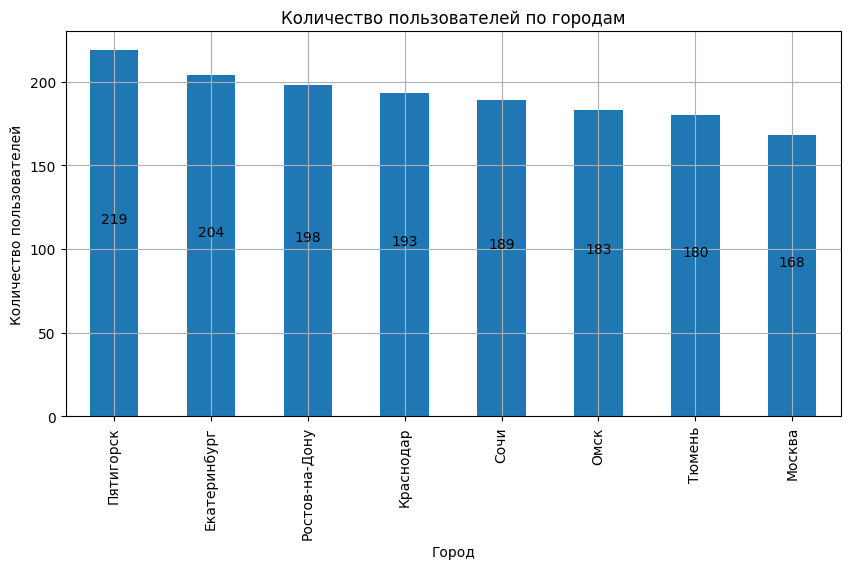

In [17]:
draw_bar(
    users_df['city'].value_counts(), 
    'cnt', 
    'Количество пользователей по городам', 
    'Город', 
    'Количество пользователей',
)

Больше всего пользователей в Пятигорске, меньше всего в Москве, но в целом в каждом городе примерно одинаковое количество пользователей от 150 до 220. Посмотрим частоту заездов по городам.

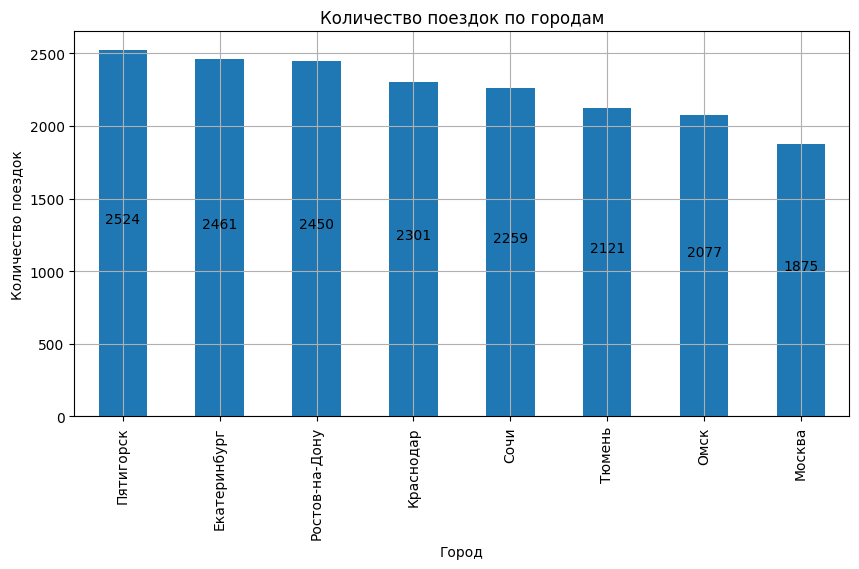

In [18]:
draw_bar(
    users_df.merge(rides_df, on='user_id')['city'].value_counts(), 
    'cnt', 
    'Количество поездок по городам', 
    'Город', 
    'Количество поездок',
)

По количеству заездов тоже лидируют Пятигорск и Екатеринбург, Москва на последнем месте.

### Соотношение пользователей с подпиской и без подписки

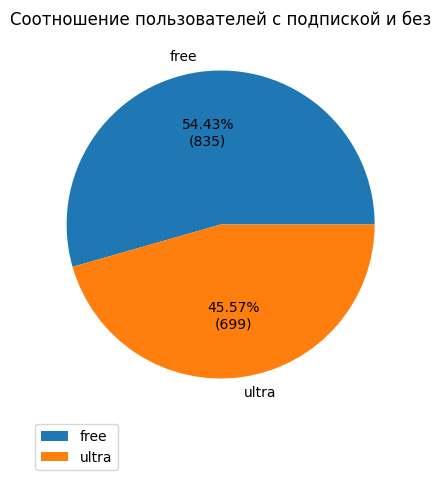

In [19]:
draw_pie(
    users_df['subscription_type'].value_counts().reset_index().set_index('subscription_type'), 
    'count', 
    'Соотношение пользователей с подпиской и без',
)

Количество пользователей с подпиской и без примерно поравну, но бесплатных на 10% больше: 54% и 45% соотвественно. 
Посмотрим соотношение поездок для пользователей с подпиской и без.

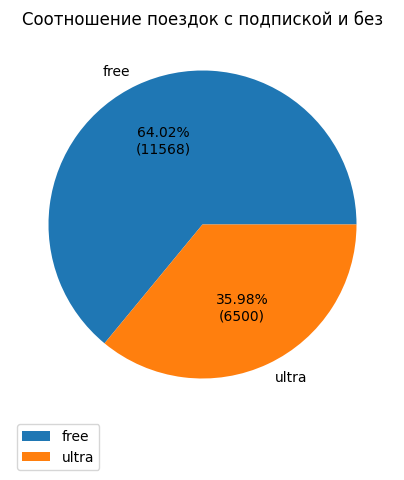

In [20]:
draw_pie(
    users_df.merge(rides_df, on='user_id')['subscription_type'].value_counts().reset_index().set_index('subscription_type'), 
    'count', 
    'Соотношение поездок с подпиской и без',
)

Количество поездок с подпиской меньше почти на 30%, чем без подписки. Кажется, что пользователи с подпиской совершают меньше поездок.

### Возраст пользователей

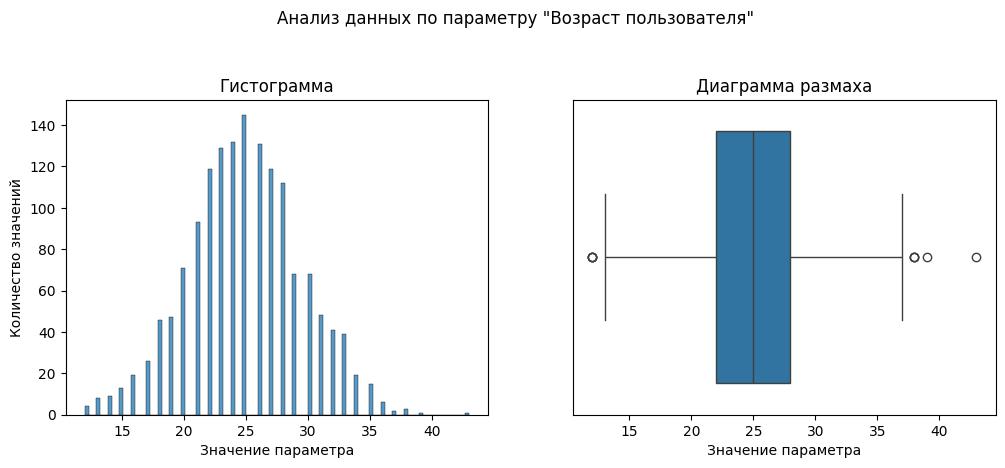

Всего значений: 1534

Среднее арифметическое значение: 24.9
Медианное значение: 25.0
В среднем значения варьируются от 22.0 до 28.0


In [21]:
draw_hist_and_box(
    users_df,
    'age', 
    'Возраст пользователя'
)

Возраст пользователей имеет равномерное распределение, и это очень похоже на правду. Никаких выбросов на графике нет. Минимальный возраст 12 лет, максимальный - 43 года. Самый часто встречающийся возраст пользователя - 25 лет (причем и медина, и среднее значение почти равны).

### Расстояние, которое пользователь преодолел за одну поездку

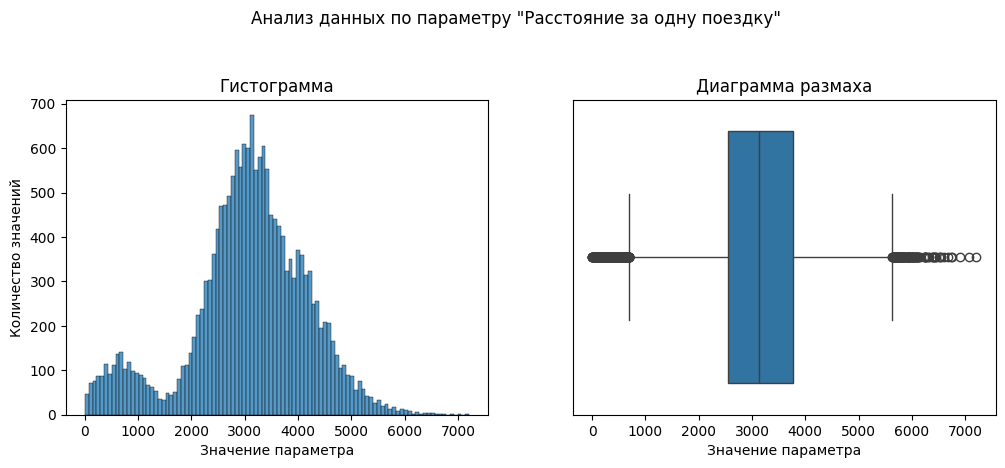

Всего значений: 18068

Среднее арифметическое значение: 3070.66
Медианное значение: 3133.61
В среднем значения варьируются от 2543.23 до 3776.22


In [22]:
draw_hist_and_box(
    rides_df,
    'distance', 
    'Расстояние за одну поездку'
)

На графике мы можем наблюдать два пика: один в районе 500м, второй в районе 3000 метров.

Такое поведение гистограммы может быть обусловлено:
- разные цели поездки (кто-то использует самокат, чтобы ежедневно добираться на работу в своем районе, а кто-то в качестве прогулки по городу в выходной день);
- сезонность: время года и время суток;
- территориальные особенности городов;
- возраст пользователя, например, можно предположить, что ребенок, оплачивает своей картой небольшие расстояния до школы и обртано;
- тарифный план пользователя, если план с подпиской, то пользователи более активно катаются на самокатах.



### Продолжительность поездок

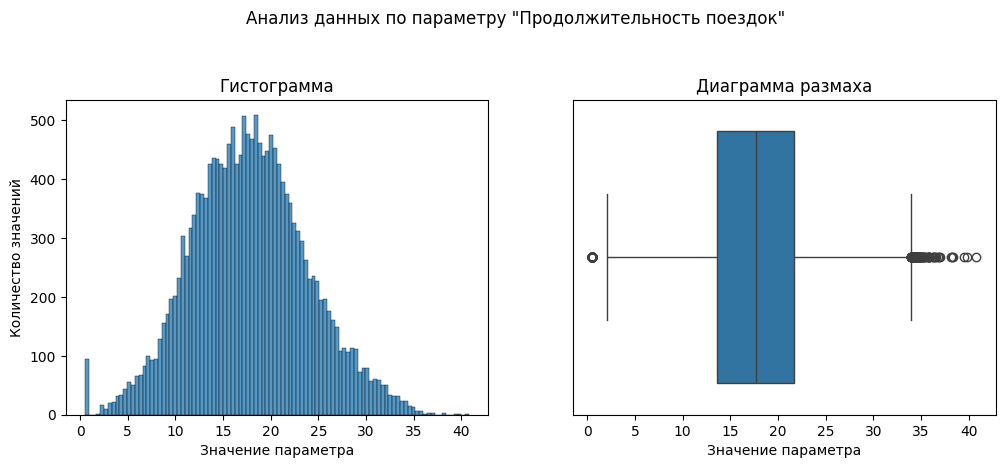

Всего значений: 18068

Среднее арифметическое значение: 17.81
Медианное значение: 17.68
В среднем значения варьируются от 13.6 до 21.72


In [23]:
draw_hist_and_box(
    rides_df,
    'duration', 
    'Продолжительность поездок'
)

В целом гистограмма выглядит красиво, значения располагаются в промежутке от 0 до 41 минуты. Гистограмма имеет один пик в районе 17-18 минут, причем медиана и среднее значение совпадает. Есть непонятный всплекс в районе 0. Посмотрим отдельно, что это за значения.

In [24]:
# Поиск значений длительности поездки меньше 5 минут
display(rides_df.query('duration < 5 ')['duration'].value_counts())

duration
0.500000    95
3.960827     1
4.456060     1
4.160957     1
2.234142     1
            ..
4.445421     1
4.998773     1
4.412563     1
2.480577     1
3.730974     1
Name: count, Length: 184, dtype: int64

In [25]:
# Поиск значений длительности поездки равных 0.5 минутам
display(rides_df.query('duration == 0.5 ').sort_values(by='distance', ascending = False))


,user_id,distance,duration,date,month
16309,1411,7211.007745,0.5,2021-04-15,4
17242,1477,6724.932981,0.5,2021-01-12,1
11385,1057,6601.197575,0.5,2021-02-07,2
13701,1224,6414.516026,0.5,2021-07-15,7
14574,1285,6316.574814,0.5,2021-09-25,9
...,...,...,...,...,...
14342,1268,4177.139336,0.5,2021-06-09,6
9698,937,4169.066800,0.5,2021-12-12,12
10692,1006,4106.278268,0.5,2021-10-31,10
17909,1524,4103.998874,0.5,2021-06-18,6


In [26]:
# Подсчет процента необычных записей
print("{:.0%}".format(len(rides_df.query('duration == 0.5 '))/len(rides_df)))

1%


Есть 95 записей в датафрейме `rides`, где длительность поездки меньше минуты. При этом расстояние поездки не менее 4 км.

Можно предположить, что это некие промокоды от сервиса, которые проставляют пользователям значения длительности меньше минуты, чтобы в дальнейшем никак их не тарифицировать. Или это какой то технический сбой. В любом случае для дальнейшего анализа такие данные нам пригодятся, оставляем их в исходном виде.

## Объединение данных

### Объединение данных о пользователях, поездках и подписках в одни датафрейм

In [27]:
#Количество строк в датафрейме users_df
print('Количество строк в датафрейме `users_df`: {0}'.format(users_df.shape[0])) 
#Количество строк в датафрейме rides_df
print('Количество строк в датафрейме `rides_df`: {0}'.format(rides_df.shape[0])) 
#Количество строк в датафрейме subscriptions_df
print('Количество строк в датафрейме `subscriptions_df`: {0}'.format(subscriptions_df.shape[0])) 

Количество строк в датафрейме `users_df`: 1534
Количество строк в датафрейме `rides_df`: 18068
Количество строк в датафрейме `subscriptions_df`: 2


In [28]:
# Объединение данных о пользователях, поездках и подписках в одни датафрейм с помощью метода merge()
data = users_df.merge(rides_df, on='user_id', how='outer').merge(subscriptions_df, on='subscription_type', how='outer')
df_analysis(data)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[n

None

****************************************************************************************************
Пропусков в датафрейме нет.
****************************************************************************************************
Количество дубликатов в датафрейме: 0 (0.00% от общего количества записей).
****************************************************************************************************


,user_id,age,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
count,18068.000000,18068.000000,18068.000000,18068.000000,18068,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,24.893071,3070.659976,17.805011,2021-06-30 19:47:21.266327296,6.486772,7.280496,32.012398,71.590658
min,1.000000,12.000000,0.855683,0.500000,2021-01-01 00:00:00,1.000000,6.000000,0.000000,0.000000
25%,487.000000,22.000000,2543.226360,13.597563,2021-04-02 00:00:00,4.000000,6.000000,0.000000,0.000000
50%,889.000000,25.000000,3133.609994,17.678395,2021-06-30 00:00:00,6.000000,8.000000,50.000000,0.000000
75%,1213.250000,28.000000,3776.222735,21.724800,2021-09-28 00:00:00,9.000000,8.000000,50.000000,199.000000
max,1534.000000,43.000000,7211.007745,40.823963,2021-12-30 00:00:00,12.000000,8.000000,50.000000,199.000000
std,434.734317,4.582216,1116.831209,6.091051,NaN,3.437410,0.959882,23.997045,95.508238


****************************************************************************************************


При формировании датафрейма с результирующими данными мы использовали режим объединения how='outer' ("объединение данных") во всех методах .merge(). В результате мы не потеряли ни одной строки, все данные по поездкам присутствуют в итоговом датафрейме.

Полученные агрегированные данные не содержат пропущенных значений, можно двигаться дальше.

### Создание двух отдельных датафреймов по пользователями без подписки и с подпиской.

In [29]:
# Создание и вывод на печать датафрейма с поездками без подписки
data_free = data.query('subscription_type == "free"')


In [30]:
# Создание и вывод на печать датафрейма с поездками с подпиской
data_ultra = data.query('subscription_type == "ultra"')


In [31]:
print(data.shape[0] == data_free.shape[0] + data_ultra.shape[0])

True


Разделение на два отдельных датафрейма тоже прошло корректно, никаких данных мы не потеряли.

### Визуализация информации о расстояниях и времени поездок для пользователей обоих категорий

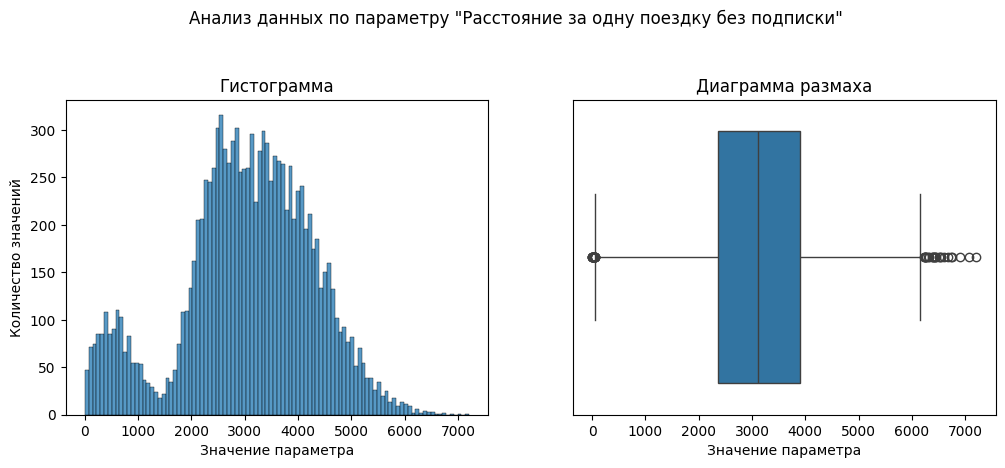

Всего значений: 11568

Среднее арифметическое значение: 3045.5
Медианное значение: 3114.65
В среднем значения варьируются от 2366.56 до 3905.7


In [32]:
draw_hist_and_box(
    data_free,
    'distance', 
    'Расстояние за одну поездку без подписки'
)

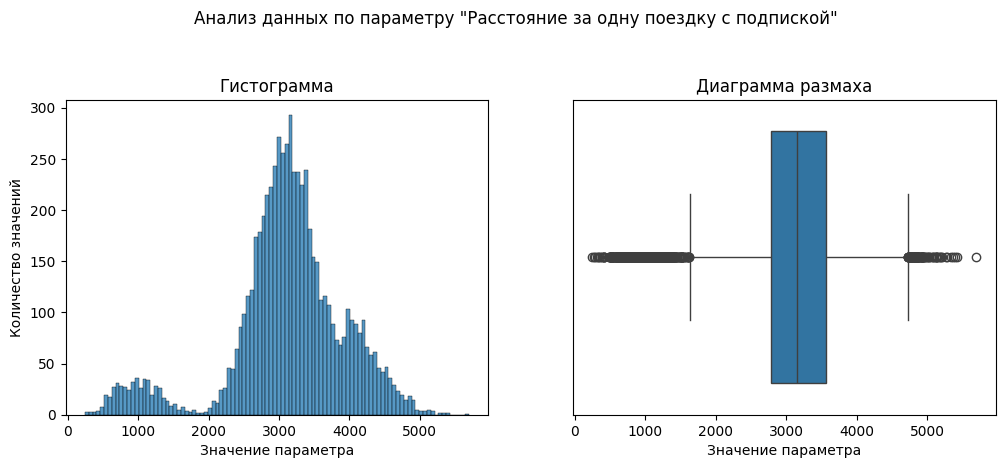

Всего значений: 6500

Среднее арифметическое значение: 3115.45
Медианное значение: 3148.64
В среднем значения варьируются от 2785.44 до 3560.57


In [33]:
draw_hist_and_box(
    data_ultra,
    'distance', 
    'Расстояние за одну поездку с подпиской'
)

Кстати, гистограммы для каждой группы значений все равно имеют два пика, несмотря на то, что мы разделили данные с подпиской и без, значит этот фактор совсем не влияет на вид гистограммы.

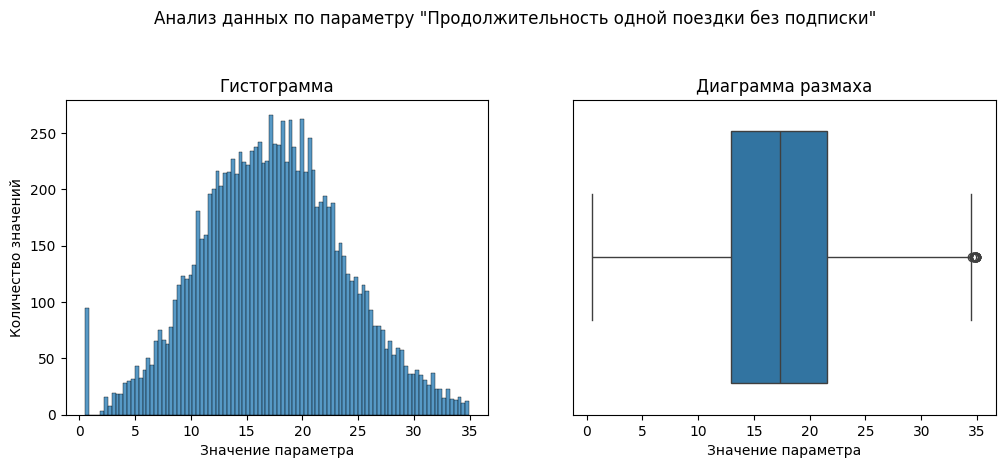

Всего значений: 11568

Среднее арифметическое значение: 17.39
Медианное значение: 17.33
В среднем значения варьируются от 12.96 до 21.59


In [34]:
draw_hist_and_box(
    data_free,
    'duration', 
    'Продолжительность одной поездки без подписки'
)

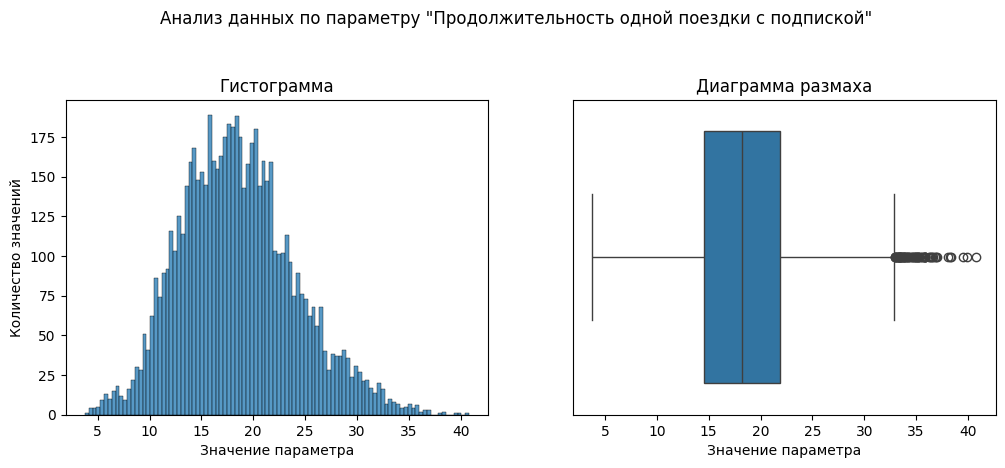

Всего значений: 6500

Среднее арифметическое значение: 18.54
Медианное значение: 18.18
В среднем значения варьируются от 14.52 до 21.88


In [35]:
draw_hist_and_box(
    data_ultra,
    'duration', 
    'Продолжительность одной поездки с подпиской'
)

Можно заметить, что необычные значения длительности поездки в 0.5 минут, характерны только для поездок без подписки.

Среднее значение расстояния поездок пользователей без подписки около 3000 метров, причем среднее и медианное значения примерно равны. Все значения колеблются от 0 до 7211 метров. У пользователей с подпиской среднее значение расстояния поездок около 3100 метров (медиана и средняя так же почти одинаковы), колебание значений от 240 до 5700 метров.

Среднее значение времени поездок пользователей без подписки около 17 минут, с подпиской 18 минут (в обоих группах колебание значений от 0 до 35-40 минут).


## Подсчёт выручки

### Создаем датафрейм с агрегированными данными о поездках: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

Продолжительность каждой поездки в каждой строке результирующего датафрейма для корректного подсчета стоимости необходимо округлять до следующего целого числа.

In [36]:
# Округление всех значенией длительности поездки до целого числа
data['duration'] = np.ceil(data['duration'])
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


In [37]:
# Создаем датафрейм с агрегированными данными о поездках: суммарное расстояние, 
# количество поездок и суммарное время для каждого пользователя за каждый месяц

data_stat = (
    data
    .pivot_table(index=['user_id', 'month', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'],values=['distance', 'duration'], aggfunc=['count', 'sum'])
)
# Сбрасываем сложный индекс
data_stat = data_stat.reset_index()

# Переименование столбцов в таблице
data_stat.columns=['user_id', 'month', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee', 'rides_cnt', 'rides_cnt_2', 'distance_sum', 'duration_sum']
# Удалим дублирующий столбец в таблице
del data_stat['rides_cnt_2']

data_stat.head()



,user_id,month,subscription_type,minute_price,start_ride_price,subscription_fee,rides_cnt,distance_sum,duration_sum
0,1,1,ultra,6,0,199,2,7027.511294,42.0
1,1,4,ultra,6,0,199,1,754.159807,7.0
2,1,8,ultra,6,0,199,2,6723.470560,46.0
3,1,10,ultra,6,0,199,2,5809.911100,32.0
4,1,11,ultra,6,0,199,3,7003.499363,56.0


### Добавим в датафрейм столбец с помесячной выручкой, которую принес каждый пользователь.

In [38]:
# Добавляем новый столбец
data_stat['gain'] = (
    data_stat['start_ride_price'] * data_stat['rides_cnt'] + 
    data_stat['minute_price'] * data_stat['duration_sum'] + 
    data_stat['subscription_fee']
)

del data_stat['minute_price']
del data_stat['start_ride_price']
del data_stat['subscription_fee']


data_stat.head()

,user_id,month,subscription_type,rides_cnt,distance_sum,duration_sum,gain
0,1,1,ultra,2,7027.511294,42.0,451.0
1,1,4,ultra,1,754.159807,7.0,241.0
2,1,8,ultra,2,6723.470560,46.0,475.0
3,1,10,ultra,2,5809.911100,32.0,391.0
4,1,11,ultra,3,7003.499363,56.0,535.0


In [39]:
# Список основных статистических характеристик данных по столбцам distance и duration датафрейма data_ultra
data_stat[['gain', 'distance_sum', 'duration_sum']].describe()

,gain,distance_sum,duration_sum
count,11331.000000,11331.000000,11331.000000
mean,342.303504,4896.362584,29.186127
std,153.875346,2911.516556,16.752464
min,58.000000,2.570787,1.000000
25%,234.000000,2972.202146,17.000000
50%,319.000000,3988.723985,24.000000
75%,415.000000,6421.375890,38.000000
max,1444.000000,23429.487786,143.000000


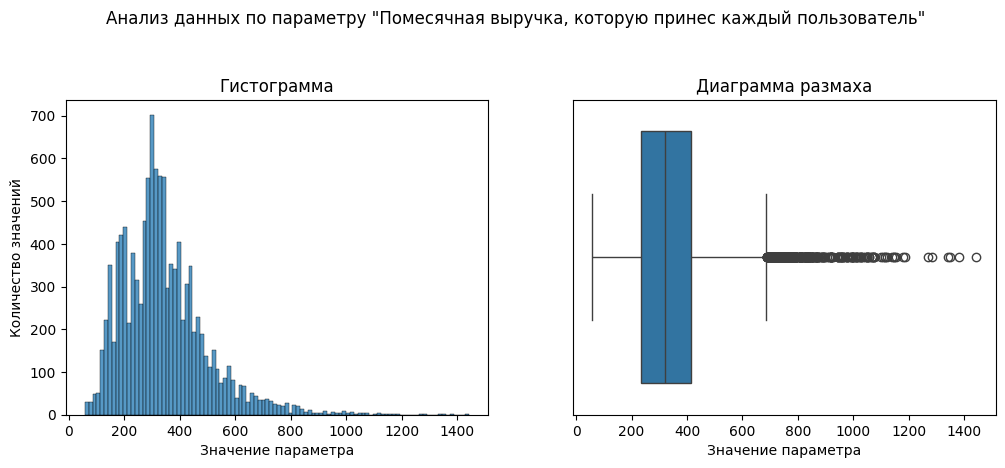

Всего значений: 11331

Среднее арифметическое значение: 342.3
Медианное значение: 319.0
В среднем значения варьируются от 234.0 до 415.0


In [40]:
draw_hist_and_box(
    data_stat,
    'gain', 
    'Помесячная выручка, которую принес каждый пользователь'
)

Гистограмма, диаграмма размаха и статистические характеристики говорят о том, что средняя помесячная выручка, которую принес каждый пользователь имеет среднее значение 320-340 рублей вне зависимости от месяца и типа подписки. Разброс значений составляет от 58 до 1444 рублей.

## Проверка гипотез

### Гипотеза: пользователи с подпиской тратят больше времени на поездки

- **Нулевая гипотеза:** средние значения длительностей поездок пользователей из двух групп равны.
- **Альтернативная гипотеза**: среднее значение длительностей поездок пользователей с подпиской больше, чем среднее значение длительностей поездок пользователей без подписки.

In [41]:
check_ttest_ind(
    data_ultra, 
    data_free, 
    'duration', 
    'greater'
)

p-value: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


**Вывод**: Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят в поездках больше времени.

In [42]:
print('Средняя продолжительность поездок без подписки - {:.2f}'.format(data_free['duration'].mean()))
print('Средняя продолжительность поездок с подпиской - {:.2f}'.format(data_ultra['duration'].mean()))

Средняя продолжительность поездок без подписки - 17.39
Средняя продолжительность поездок с подпиской - 18.54


В целом разница средних значений длительности поездок с подпиской и без отличается на 1 минуту.

### Гипотеза: расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

- **Нулевая гипотеза:** средние расстояние поездки пользователей с подпиской равно 3130 метров.
- **Альтернативная гипотеза**: среднее расстояние поездки пользователей с подпиской больше, чем 3130.


In [43]:
duration_mx = 3130

check_ttest_1samp(
    data_ultra, 
    'distance', 
    duration_mx, 
    'greater'
)

p-value: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


**Вывод**: Полученное значение p-value больше заданного уровня значимости, поэтому у нас недостаточно оснований для того, чтобы отвергнуть нулевую гипотезу. 


In [44]:
print('Средняя расстояние поездок с подпиской - {:.2f}'.format(data_ultra['distance'].mean()))

Средняя расстояние поездок с подпиской - 3115.45


### Гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

- **Нулевая гипотеза:** средняя помесячная выручка от пользователей из двух групп равна.
- **Альтернативная гипотеза**: средняя помесячная выручка от пользователей с подпиской больше, чем средняя помесячная выручка от пользователей без подписки.

In [45]:
check_ttest_ind(
    data_stat[data_stat['subscription_type']=='ultra'], 
    data_stat[data_stat['subscription_type']=='free'], 
    'gain', 
    'greater'
)

p-value: 8.874140893976874e-40
Отвергаем нулевую гипотезу


**Вывод**: Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что помесячная выручка от пользователей с подпиской больше, чем у пользователей без подписки.

In [46]:
print('Средняя помесячная выручка пользователей без подписки - {:.2f}'.format(data_stat[data_stat['subscription_type']=='free']['gain'].mean()))
print('Средняя помесячная выручка пользователей с подпиской - {:.2f}'.format(data_stat[data_stat['subscription_type']=='ultra']['gain'].mean()))

Средняя помесячная выручка пользователей без подписки - 328.64
Средняя помесячная выручка пользователей с подпиской - 362.79


### Гипотеза про обращение в тех.поддержку

В данном случае будут анализироваться две зависимые выборки. Будет проверяться гипотеза о равенстве среднего значения генеральной совокупности до и после изменения

Использовать в такой ситуации правильно метод **scipy.stats.ttest_rel**. Аргументы - парные выборки до и после изменения, а так же alternative='greater' - проверится правосторонняя гипотеза, истинное среднее генеральной совокупности после изменения меньше, чем до изменений.


## Распределения

### Акция с промокодами

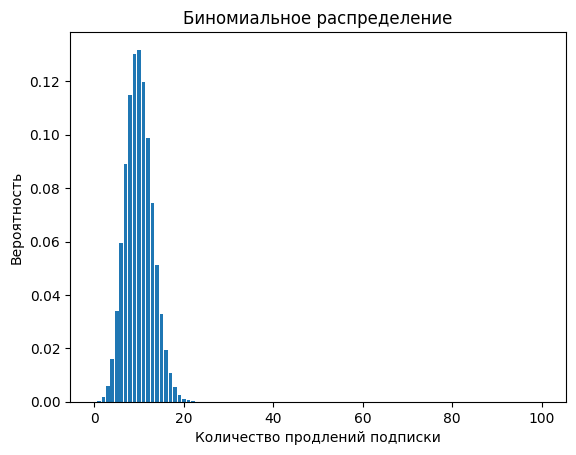

In [47]:
p = 0.1  # Вероятность продления подписки
n = 100  # Количество клиентов, которые должны продлить подписку

distr = []

count = n + 1

for k in range(0, count):
    current_value = stats.binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, count), distr)
plt.xlabel("Количество продлений подписки")
plt.ylabel("Вероятность")
plt.title("Биномиальное распределение")
plt.show()



В целом разница средних значений длительности поездок с подпиской и без отличается на 1 минуту.

Метод .cdf() выведет вероятность, с которой выполняется удачное действие **k** раз с вероятность удачи **p** при общем количестве действий **n** раз.

Значит нам надо подобрать такое значение **n**, при котором **k = 100** (ровно столько подписчиков нам нужно) с вероястностью удачи **p = 0.1** (10% продлевают подписку).

Переберем в цикле от 100 и найдем такое значение, при котором вероятность все еще больше 5%

In [48]:
p = 0.1  # Вероятность продления подписки
k = 100  # Количество клиентов, которые должны продлить подписку

i = 100
current_n = 1

while current_n > 0.05:
    current_n = stats.binom.cdf(k=k, n=i, p=p)
    i +=1

print('Необходимо разослать', i, 'промокодов')
print('Вероятность не выполнить план будет равна - {:.2%}'.format(current_n))



Необходимо разослать 1173 промокодов
Вероятность не выполнить план будет равна - 4.95%


### Push-уведомления в мобильном приложении

Биномиальное распределение можно апроксимировать нормальным распределением. Математическое ожидание и стандартное отклонение нормального распределения, которым аппроксимируется биномиальное, просто берутся равными математическому ожиданию и стандартному отклонения биномиального распределения.

In [49]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = stats.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399500
result = distr.cdf(399500)
print('Вероятность того, что уведомление откроют 399,5 тыс пользователей - {:.2%} '.format(result))

Вероятность того, что уведомление откроют 399,5 тыс пользователей - 15.37% 


## Общий вывод

### Входные данные

В вашем распоряжении были данные сервиса аренды самокатов GoFast — данные о некоторых пользователях из нескольких городов, а так же об их поездках.

Было необходимо провести исследовательский анализ данных и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Описание данных:**

В основных данных есть информация о пользователях, их поездках и подписках.

***Пользователи***
- `user_id` -   уникальный идентификатор пользователя
- `name`    -   имя пользователя
- `age` -   возраст
- `city`    -   город
- `subscription_type`   -   тип подписки (free, ultra)

***Поездки***
- `user_id` -   уникальный идентификатор пользователя
- `distance`    -   расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration`    -   продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date`    -   дата совершения поездки

***Подписки***
- `subscription_type`   -   тип подписки
- `minute_price`    -   стоимость одной минуты поездки по данной подписке
- `start_ride_price`    -   стоимость начала поездки
- `subscription_fee`    -   стоимость ежемесячного платежа


### Анализ и преобработка данных

1. Во всех предложенных датафреймах столбцы имеют правильное и корректное название, никаких преобразований делать не надо было.
2. Выявлено несоотвествия типа данных в датафрейме `rides`: `date` преобразован в `datetime64[ns]`.
3. Добавлен новый столбец в датафрейм `rides` `month` - номер месяца на основе столбца `date`.
4. Не выявлено пропущенных значений.
5. Удалены явные дубликаты в users (2%), в других датафреймах дубли не выявлены.



### Исследовательский анализ данных

***Частота втречаемости городов***

Больше всего пользователей в Пятигорске, меньше всего в Москве, но в целом в каждом городе примерно одинаковое количество пользователей от 150 до 220. 

По количеству заездов тоже лидируют Пятигорск и Екатеринбург, Москва на последнем месте. Значения по городам распределены в пределе от 1800 до 2550 поездок.


***Соотношение пользователей с подпиской и без***

Количество пользователей с подпиской и без примерно поравну, но бесплатных на 10% больше: 54% и 45% соотвественно. 

Количество поездок с подпиской меньше почти на 30%, чем без подписки. Кажется, что пользователи с подпиской совершают меньше поездок.


***Возраст пользователей***

Возраст пользователей имеет равномерное распределение, и это очень похоже на правду. Никаких всплесков на графике нет. Минимальный возраст 12 лет, максимальный - 43 года. Самый часто встречающийся возраст пользователя - 25 лет (причем и медина, и среднее значение почти равны).


***Расстояние, которое пользователь преодолел за одну поездку***

На графике мы смогли наблюдать два пика: один в районе 500м, второй в районе 3000 метров.

Такое поведение гистограммы может быть обусловлено:
- разные цели поездки (кто-то использует самокат, чтобы ежедневно добираться на работу в своем районе, а кто-то в качестве прогулки по городу в выходной день);
- сезонность: время года и время суток;
- территориальные особенности городов;
- возраст пользователя, например, можно предположить, что ребенок, оплачивает своей картой небольшие расстояния до школы и обртано.

После того, как данные о поездках были выделены в две отдельные группы, два пика все так же остались на каждой гистограмме в отдельности, значит тарифный план не влияет на такое поведение.

Среднее значение расстояния поездок пользователей без подписки около 3000 метров, причем среднее и медианное значения примерно равны.

Среднее значение расстояния поездок пользователей без подписки около 3100 метров, среднее и медианное значения так же примерно равны.

***Продолжительность поездок***

На гистограмме можно наблюдать небольшой пик в районе нулевых значений, более внимательный анализ показал, что есть 95 записей в датафрейме rides с длительностью поездки меньше минуты (причем все такие значения у пользователей без подписки). При этом расстояние поездки не менее 4 км. Эти значения мы никак не удаляли и не изменяли, оставили в исходном состоянии.

Можно предположить, что это некие промокоды от сервиса, которые проставляют пользователям значения длительности меньше минуты, чтобы в дальнейшем никак их не тарифицировать. Или это какой то технический сбой. В любом случае для дальнейшего анализа такие данные нам пригодятся.

После того, как данные о поездках были выделены в две отдельные группы, параметр был проанализироввн отдельно для каждой группы. 

Среднее значение времени поездок пользователей без подписки около 17 минут.

Среднее значение времени поездок пользователей без подписки около 18 минут.

***Подсчет выручки***

На основе всех данных был сформирован новый датафрейм `data_stat` с агрегированными данными о поездках на основе основного датафрейма: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. 

Добавлен столбец с помесячной выручкой, которую принес каждый пользователь. Для этого мы обратились к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продлжительность каждой поездки в каждой строке исходного датафрейма для подсчета стоимости округлили до следующего целого числа.

Средняя помесячная выручка, которую принес каждый пользователь имеет среднее значение 320-340 рублей вне зависимости от месяца и типа подписки. Разброс значений составляет от 58 до 1444 рублей.

### Проверка гипотез

**Гипотеза: пользователи с подпиской тратят больше времени на поездки**

- ***Нулевая гипотеза***: средние значения длительностей поездок пользователей из двух групп равны.
- ***Альтернативная гипотеза***: среднее значение длительностей поездок пользователей с подпиской больше, чем среднее значение длительностей поездок пользователей без подписки.

p-value получили меньше уровня значимости в 5%

**Вывод**: Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят в поездках больше времени.

Действительно:

Средняя продолжительность поездок без подписки - 17.39 минут

Средняя продолжительность поездок с подпиской - 18.54 минут

В целом разница средних значений длительности поездок с подпиской и без отличается на 1 минуту.


**Гипотеза: расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров**

- ***Нулевая гипотеза***: средние расстояние поездки пользователей с подпиской равно 3130 метров.
- ***Альтернативная гипотеза***: среднее расстояние поездки пользователей с подпиской больше, чем 3130.

p-value получили больше уровня значимости в 5%

**Вывод**: Полученное значение p-value больше заданного уровня значимости, поэтому у нас недостаточно оснований для того, чтобы отвергнуть нулевую гипотезу. 

Средняя расстояние поездок с подпиской - 3115.45


**Гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки**

- ***Нулевая гипотеза***: средняя помесячная выручка от пользователей из двух групп равна.
- ***Альтернативная гипотеза***: средняя помесячная выручка от пользователей с подпиской больше, чем средняя помесячная выручка от пользователей без подписки.

p-value получили меньше уровня значимости в 5%

**Вывод**: Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что помесячная выручка от пользователей с подпиской больше, чем у пользователей без подписки.

Действительно:

Средняя помесячная выручка пользователей без подписки - 328.64

Средняя помесячная выручка пользователей с подпиской - 362.79

**Гипотеза про обращение в тех.поддержку**

В данном случае будут анализироваться две зависимые выборки. Будет проверяться гипотеза о равенстве среднего значения генеральной совокупности до и после изменения
Использовать в такой ситуации правильно метод scipy.stats.ttest_rel. Аргументы - парные выборки до и после изменения, а так же alternative='greater' - проверится правосторонняя гипотеза, истинное среднее генеральной совокупности после изменения меньше, чем до изменений.




### Задания на тему "Распределение"

**Промокоды**

Метод .cdf() выведет вероятность, с которой выполняется удачное действие k раз с вероятность удачи p при общем количестве действий n раз.

Значит нам надо подобрать такое значение n, при котором k = 100 (ровно столько подписчиков нам нужно) с вероястностью удачи p = 0.1 (10% продлевают подписку).

Переберем в цикле от 100 и найдем такое значение, при котором вероятность все еще больше 5%

Необходимо разослать 1173 промокодов

Вероятность не выполнить план будет равна - 4.95%


**Push-уведомления в мобильном приложении**

Биномиальное распределение можно апроксимировать нормальным распределением. Математическое ожидание и стандартное отклонение нормального распределения, которым аппроксимируется биномиальное, просто берутся равными математическому ожиданию и стандартному отклонения биномиального распределения.

Вероятность того, что уведомление откроют 399,5 тыс пользователей - 15.37% 



### Итог

Мы получили данные, предобработали их там, где это было необходимо, проанализировали отдельные показатели поездок. Построили графики, по исследуемым данным. Проанализировалы данные о поездках в зависимости от подписки пользователя.

Создали таблицу с агрегированными данными и помесячной выручкой по каждому пользователю.

В результате исследования можно сделать вывод, что пользователи с подпиской тратят больше времени на поездки, при этом пользователей примерно равное количества с подписикой и без, а вот самих поездок пока гораздо меньше (почти на 30%).

Средняя выручка от пользователей с подпиской больше, чем без подписки.

Гипотезу о том, что расстояние одной поездки в 3130 метров, оптимальное с точки зрания износа самоката, в среднем равно расстоянию поездки для пользоватлей с подпиской опровергнуть не получилось: недостаточно оснований по текущей выборке данных.